## Imports

In [2]:
import nltk
from pathlib import Path
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

### Figure 2a

Which topics are shared the most?
{'Benefits': 3,
 'Births, deaths, marriages and care': 21,
 'Business and self-employed': 300,
 'Childcare and parenting': 6,
 'Citizenship and living in the UK': 6,
 'Coronavirus (COVID-19)': 36,
 'Crime, justice and the law': 21,
 'Driving and transport': 55,
 'Education, training and skills': 28,
 'Environment and countryside': 15,
 'Housing and local services': 10,
 'Money and tax': 36,
 'Passports, travel and living abroad': 3,
 'Visas and immigration': 6,
 'Working, jobs and pensions': 36}
[(' Education and Skills Funding Agency', 'Cabinet Office', 1),
 (' Education and Skills Funding Agency', 'Civil Service Fast Stream', 1),
 (' Education and Skills Funding Agency', 'DWP', 1),
 (' Education and Skills Funding Agency', 'DfE', 1),
 (' Education and Skills Funding Agency', 'Government Equalities Office', 1),
 (' Education and Skills Funding Agency', 'Insolvency Service', 1),
 (' Education and Skills Funding Agency', 'Ministry of Defence', 1),
 (' E

c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1072: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


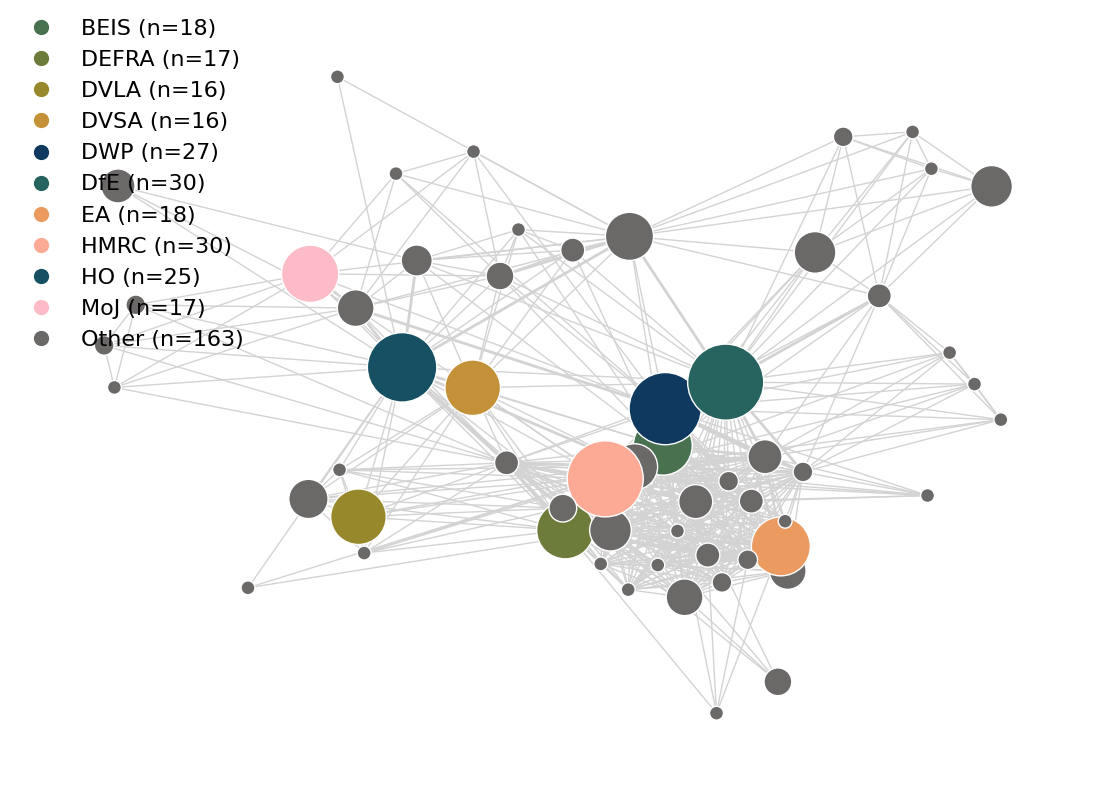

In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns


def plot_organisation_network(save=False):
    """
    Load and plot organisations network.
    """
    
    # Assuming services_df is your DataFrame
    services_df = pd.read_pickle(Path('../data/processed/dataframes/descriptive-df-w-api-data.pkl'))

    # Abbreviate organisation names
    mapping = {
        'Department for Business, Energy & Industrial Strategy': 'BEIS', 
        'Department for Environment, Food & Rural Affairs': 'DEFRA',
        'Department for Education' : 'DfE',
        'Department for Work and Pensions': 'DWP',
        'Driver and Vehicle Licensing Agency': 'DVLA',
        'Driver and Vehicle Standards Agency': 'DVSA',
        'HM Revenue and Customs': 'HMRC', 
        'Home Office': 'HO',
        'Ministry of Justice': 'MoJ',
        'Environment Agency': 'EA'
    }
    
    services_df.replace(mapping, inplace=True) 
    
    # Task 1: Create a NetworkX graph
    G = nx.Graph()
    
    # Define palette
    PALETTE = [
    '#48714f', '#6d7c3b', '#97882c', '#c49138',
    '#0f395f', '#27635f',
    '#eb9a60', '#fca995', '#165062', '#fdbac7'
    ]

    # Add nodes for organizations
    org_service_count = services_df.groupby('organisation')['service'].nunique().reset_index()
    org_service_count.columns = ['organisation', 'service_count']

    # Create a list to store colors for nodes
    node_colors = []

    # Task 1.1: Assign unique colors to nodes with 15 or more services
    unique_colors = sns.color_palette(PALETTE, n_colors=10)  # Use Set1 colormap
    color_mapping = dict(zip(org_service_count.loc[org_service_count['service_count']>=15].organisation, unique_colors))

    for index, row in org_service_count.iterrows():
        if row['service_count'] >= 15:
            G.add_node(row['organisation'], size=row['service_count'], color=row['service_count'])
            node_colors.append(color_mapping[row['organisation']])  # Use a unique color for nodes with 15 or more services
        else:
            G.add_node(row['organisation'], size=row['service_count'], color=0)  # 0 represents 'Other' nodes
            node_colors.append('#6b6868')  # Color nodes with less than 15 services as #e6e4cc

    # Task 2: Add edges between organizations based on shared topics, edge weight based on the number of shared topics
    # Also keep account of which service topics are most commonly shared
    num_shares = {}
    seen_orgs = [] #keep track so we don't do edges twice
    edges = []
    for org1 in org_service_count['organisation']:
        for org2 in org_service_count['organisation']:
            if org1 != org2 and (org1, org2) not in seen_orgs:
                topics1 = set(services_df[services_df['organisation'] == org1]['topic'])
                topics2 = set(services_df[services_df['organisation'] == org2]['topic'])
                shared_topics = topics1.intersection(topics2)
                if shared_topics:
                    G.add_edge(org1, org2, weight=len(shared_topics))
                    edges.append((org1, org2, len(shared_topics)))
                    
                    #add num share statistics
                    for top in shared_topics:
                        if not top in num_shares:
                            num_shares[top] = 0
                        num_shares[top] += 1

                    #add the reverse of this edge to make sure we don't do it again 
                    seen_orgs.append((org2, org1))

    print('Which topics are shared the most?')
    import pprint
    pprint.pprint(num_shares)

    #edge list
    pprint.pprint(edges)

    # Get node sizes
    node_sizes = [data['size'] * 100 for _, data in G.nodes(data=True)]

    # Get edge weights
    edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]

    # Create a force-directed layout
    pos = nx.spring_layout(G)
    
    # Draw the network diagram
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, linewidths=1, edgecolors='white')
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='lightgrey')

    # No need to draw node labels separately

    # Task 3: Create a custom legend for nodes with 15 or more services and 'Other' nodes
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=12, label=f'{org} (n={count})')
                       for org, count, color in zip(org_service_count['organisation'], org_service_count['service_count'], node_colors)
                       if count >= 15]  # Filter nodes with 15 or more services

    # Add a label for 'Other' nodes
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#6b6868', markersize=12, label='Other (n=163)'))

    # Create legend in the lower left
    plt.legend(handles=legend_elements, borderaxespad=0., loc='upper left', frameon=False, fontsize=16, ncol=1)

    plt.axis('off')

    # Save figure
    if save == True:
        plt.savefig(Path("../reports/figures/fig2a.png"), dpi=300, bbox_inches='tight')
    else:
        plt.show()
        
    
plot_organisation_network(
    save=True
)

**Interpretation**
- There is a central cluster of organisations that offer the most services; this is perhaps where efforts to adopt automation should be concentrated

### Figure 2b

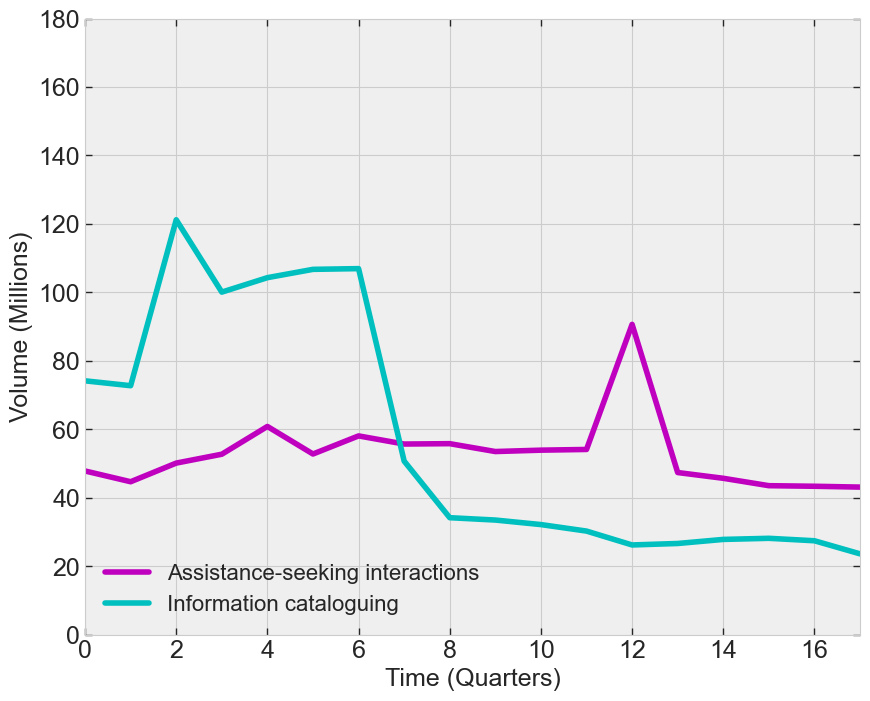

In [215]:
def plot_transactions_data(save=False):
    """
    Load and plot processed transactions data.
    """

    transactions_data = pd.read_csv(Path('../data/processed/201204-201703-service-transactions-processed.csv'))

    # Remove passenger arrivals
    transactions_df = transactions_data.loc[transactions_data['Service'] != 'Passenger arrivals at the UK border']

    # Create a dictionary to map digital columns to non-digital counterparts
    column_mapping = {}
    for col in transactions_df.columns:
        if 'digital' in col:
            quarter = col[:-7]  # Remove 'digital' to get the quarter
            column_mapping[col] = quarter

    #### Per Servicetype
    # Group by 'Servicetype'/'Service' and sum the columns
    servicetype_grouped_df = transactions_df.groupby('Servicetype').agg({col: 'sum' for col in column_mapping.values()})

    # Rename the columns
    servicetype_grouped_df = servicetype_grouped_df.rename(columns=column_mapping)

    # Reset the index to make 'Servicetype' a regular column
    servicetype_grouped_df.reset_index(inplace=True)

    # Reshape the DataFrame using melt
    melted = pd.melt(servicetype_grouped_df, id_vars=['Servicetype'], var_name='Quarter', value_name='Volume')

    # Convert the 'Year' column to an integer
    melted['Quarter'] = melted['Quarter'].astype(int)

    # Group by 'Servicetype' and 'Year' and calculate the sum of 'Volume'
    final_df = melted.groupby(['Servicetype', 'Quarter'])['Volume'].sum().reset_index()

    # Convert 'Quarter' column to a datetime format for easier comparison
    final_df['Quarter'] = pd.to_datetime(final_df['Quarter'], format='%Y%m')

    # Sort the DataFrame by 'Servicetype' and 'Quarter'
    final_df = final_df.sort_values(by=['Servicetype', 'Quarter'])

    # Define a mapping of new 'Servicetype' values
    servicetype_mapping = {
        'Requesting a licence or consent': 'Assistance-seeking interactions',
        'Requesting benefits payments or loans': 'Assistance-seeking interactions',
        'Booking events and resources': 'Assistance-seeking interactions',
        'Making a payment': 'Assistance-seeking interactions',
        'Ordering goods': 'Assistance-seeking interactions',
        'Registering': 'Information cataloguing',
        'Providing information': 'Information cataloguing',
        'Requesting information': 'Information cataloguing',
        'Amending/deleting information': 'Information cataloguing',
    }

    # Apply the mapping to create a new 'Servicetype' column
    final_servicetype_df = final_df.copy()
    final_servicetype_df['NewServicetype'] = final_df['Servicetype'].map(servicetype_mapping)

    # Group by the new 'Servicetype' column and sum the values for all other columns
    collapsed_df = final_servicetype_df.groupby(['NewServicetype', 'Quarter']).sum().reset_index()

    # Drop the original 'Servicetype' column
    collapsed_df.drop('Servicetype', axis=1, inplace=True)

    # Create quarter mapping
    quarter_mapping = dict(zip(list(collapsed_df.Quarter.unique()), list(range(0, 18, 1))))
    collapsed_df['Quarter'] = collapsed_df['Quarter'].map(quarter_mapping)

    # Convert 'Volume' to millions
    collapsed_df['Volume_Millions'] = collapsed_df['Volume'] / 1000000

    # Create a time series plot for 'InitialDeltaPerc' with customizations
    plt.figure(figsize=(10, 8))

    # Determine the color palette based on the final values
    color_dict = {
        'Information cataloguing': 'c',
        'Assistance-seeking interactions': 'm'

    }

    plt.tick_params(
        axis='both',
        which='both',
        direction='in',
        top=True,
        right=True,
        bottom=True,
        left=True,
        labelsize=18,
        width=1,
        length=5
    )

    # Plot lines for individual 'NewServicetype' values with custom colors
    for newservicetype in collapsed_df['NewServicetype'].unique():
        data = collapsed_df[collapsed_df['NewServicetype'] == newservicetype]
        y_data = data['Volume_Millions']

        # Use the corresponding color for the 'Servicetype'
        color = color_dict[newservicetype]

        # Plot the line with a color representing the final value
        plt.plot(data['Quarter'], y_data, label=newservicetype, color=color, linewidth=4)

    # Set the face color
    plt.gca().set_facecolor('#efefef')

    # Set axis labels and font size
    plt.xlabel('', fontsize=18)
    plt.ylabel('', fontsize=18)

    plt.legend(title='', frameon=False,
               loc='lower left',
               prop={'family': 'Arial', 'size': 16}
              )
    plt.title('')
    plt.xlabel('Time (Quarters)', fontname='Arial')
    plt.ylabel('Volume (Millions)', fontname='Arial')
    plt.ylim((0, 180))
    plt.xlim(0, 17)
    
    # Save figure
    if save == True:
        plt.savefig(Path("../reports/figures/fig2b.png"), dpi=300, bbox_inches='tight')
    else:
        plt.show()

plot_transactions_data()

#### Figure 2b inset

<Figure size 1000x800 with 0 Axes>

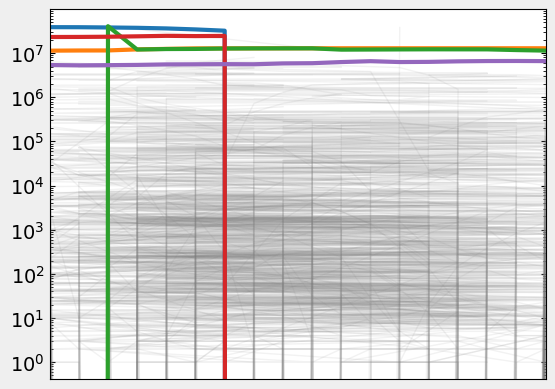

In [6]:
def plot_transactions_inset_data(save=False):

    # Load data
    transactions_data = pd.read_csv(Path('../data/processed/201204-201703-service-transactions-processed.csv'))

    # Remove passenger arrivals
    transactions_df = transactions_data.loc[transactions_data['Service'] != 'Passenger arrivals at the UK border']
    
    # Create a dictionary to map digital columns to non-digital counterparts
    column_mapping = {}
    for col in transactions_df.columns:
        if 'digital' in col:
            quarter = col[:-7]  # Remove 'digital' to get the quarter
            column_mapping[col] = quarter
    
    # Get service dataframe
    service_grouped_df = transactions_df.groupby('Service').agg({col: 'sum' for col in column_mapping.values()})
    service_grouped_df = service_grouped_df.rename(columns=column_mapping)
    service_grouped_df.reset_index(inplace=True)
    service_melted_df = pd.melt(service_grouped_df, id_vars=['Service'], var_name='Quarter', value_name='Volume')
    service_melted_df['Quarter'] = service_melted_df['Quarter'].astype(int)
    service_df = service_melted_df.groupby(['Service', 'Quarter'])['Volume'].sum().reset_index()
    service_df['Quarter'] = pd.to_datetime(service_df['Quarter'], format='%Y%m')
    service_df = service_df.sort_values(by=['Service', 'Quarter'])

    # Create quarter mapping
    quarter_mapping = dict(zip(list(service_df.Quarter.unique()), list(range(0, 18, 1))))
    service_df['Quarter'] = service_df['Quarter'].map(quarter_mapping)

    # Create a time series plot for 'InitialDeltaPerc' with customizations
    plt.figure(figsize=(10, 8))

    # Face color
    plt.figure(facecolor='#efefef')
    
    # Sort the data by volume in descending order
    sorted_data = service_df.sort_values(by='Volume', ascending=False)

    # Plot lines for individual 'NewServicetype' values with custom colors
    for service in sorted_data['Service'].unique():
        data = sorted_data[sorted_data['Service'] == service]
        y_data = data['Volume']

        # Use the corresponding color for the 'Servicetype'
        # color = color_dict[servicetype]

        # Plot the line with a color representing the final value
        plt.plot(data['Quarter'], y_data, label=service, color='gray', alpha=.1, linewidth=1) 


    for top_service in service_df.groupby('Service')[['Volume']].sum().sort_values(
        by='Volume', ascending=False).head(5).reset_index().Service:
        data = service_df[service_df['Service'] == top_service]
        y_data = data['Volume']

        # Use the corresponding color for the 'Servicetype'
        # color = color_dict[servicetype]

        # Plot the line with a color representing the final value
        plt.plot(data['Quarter'], y_data, label=service, linewidth=3) 


    plt.tick_params(
        axis='both',
        which='both',
        direction='in',
        top=True,
        right=True,
        bottom=True,
        left=True,
    )

    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.yscale('log')
    plt.xlim(0, 17)
    plt.xticks([])
    plt.yticks(fontsize=14)

    # Save figure
    if save == True:
        plt.savefig(Path("../reports/figures/fig2b-inset.png"), dpi=300, bbox_inches='tight')
    else:
        plt.show()

plot_transactions_inset_data()

**Interpretation**
- There is a change from information cataloguing to interactive services
- Overall transactions stay relatively stable over time
- The patterns can mostly be accounted for by trends in a few major services that either disappear or persist

### Figure 2d

C:\Users\VincentS\AppData\Local\Temp\ipykernel_22672\1669590177.py:96: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


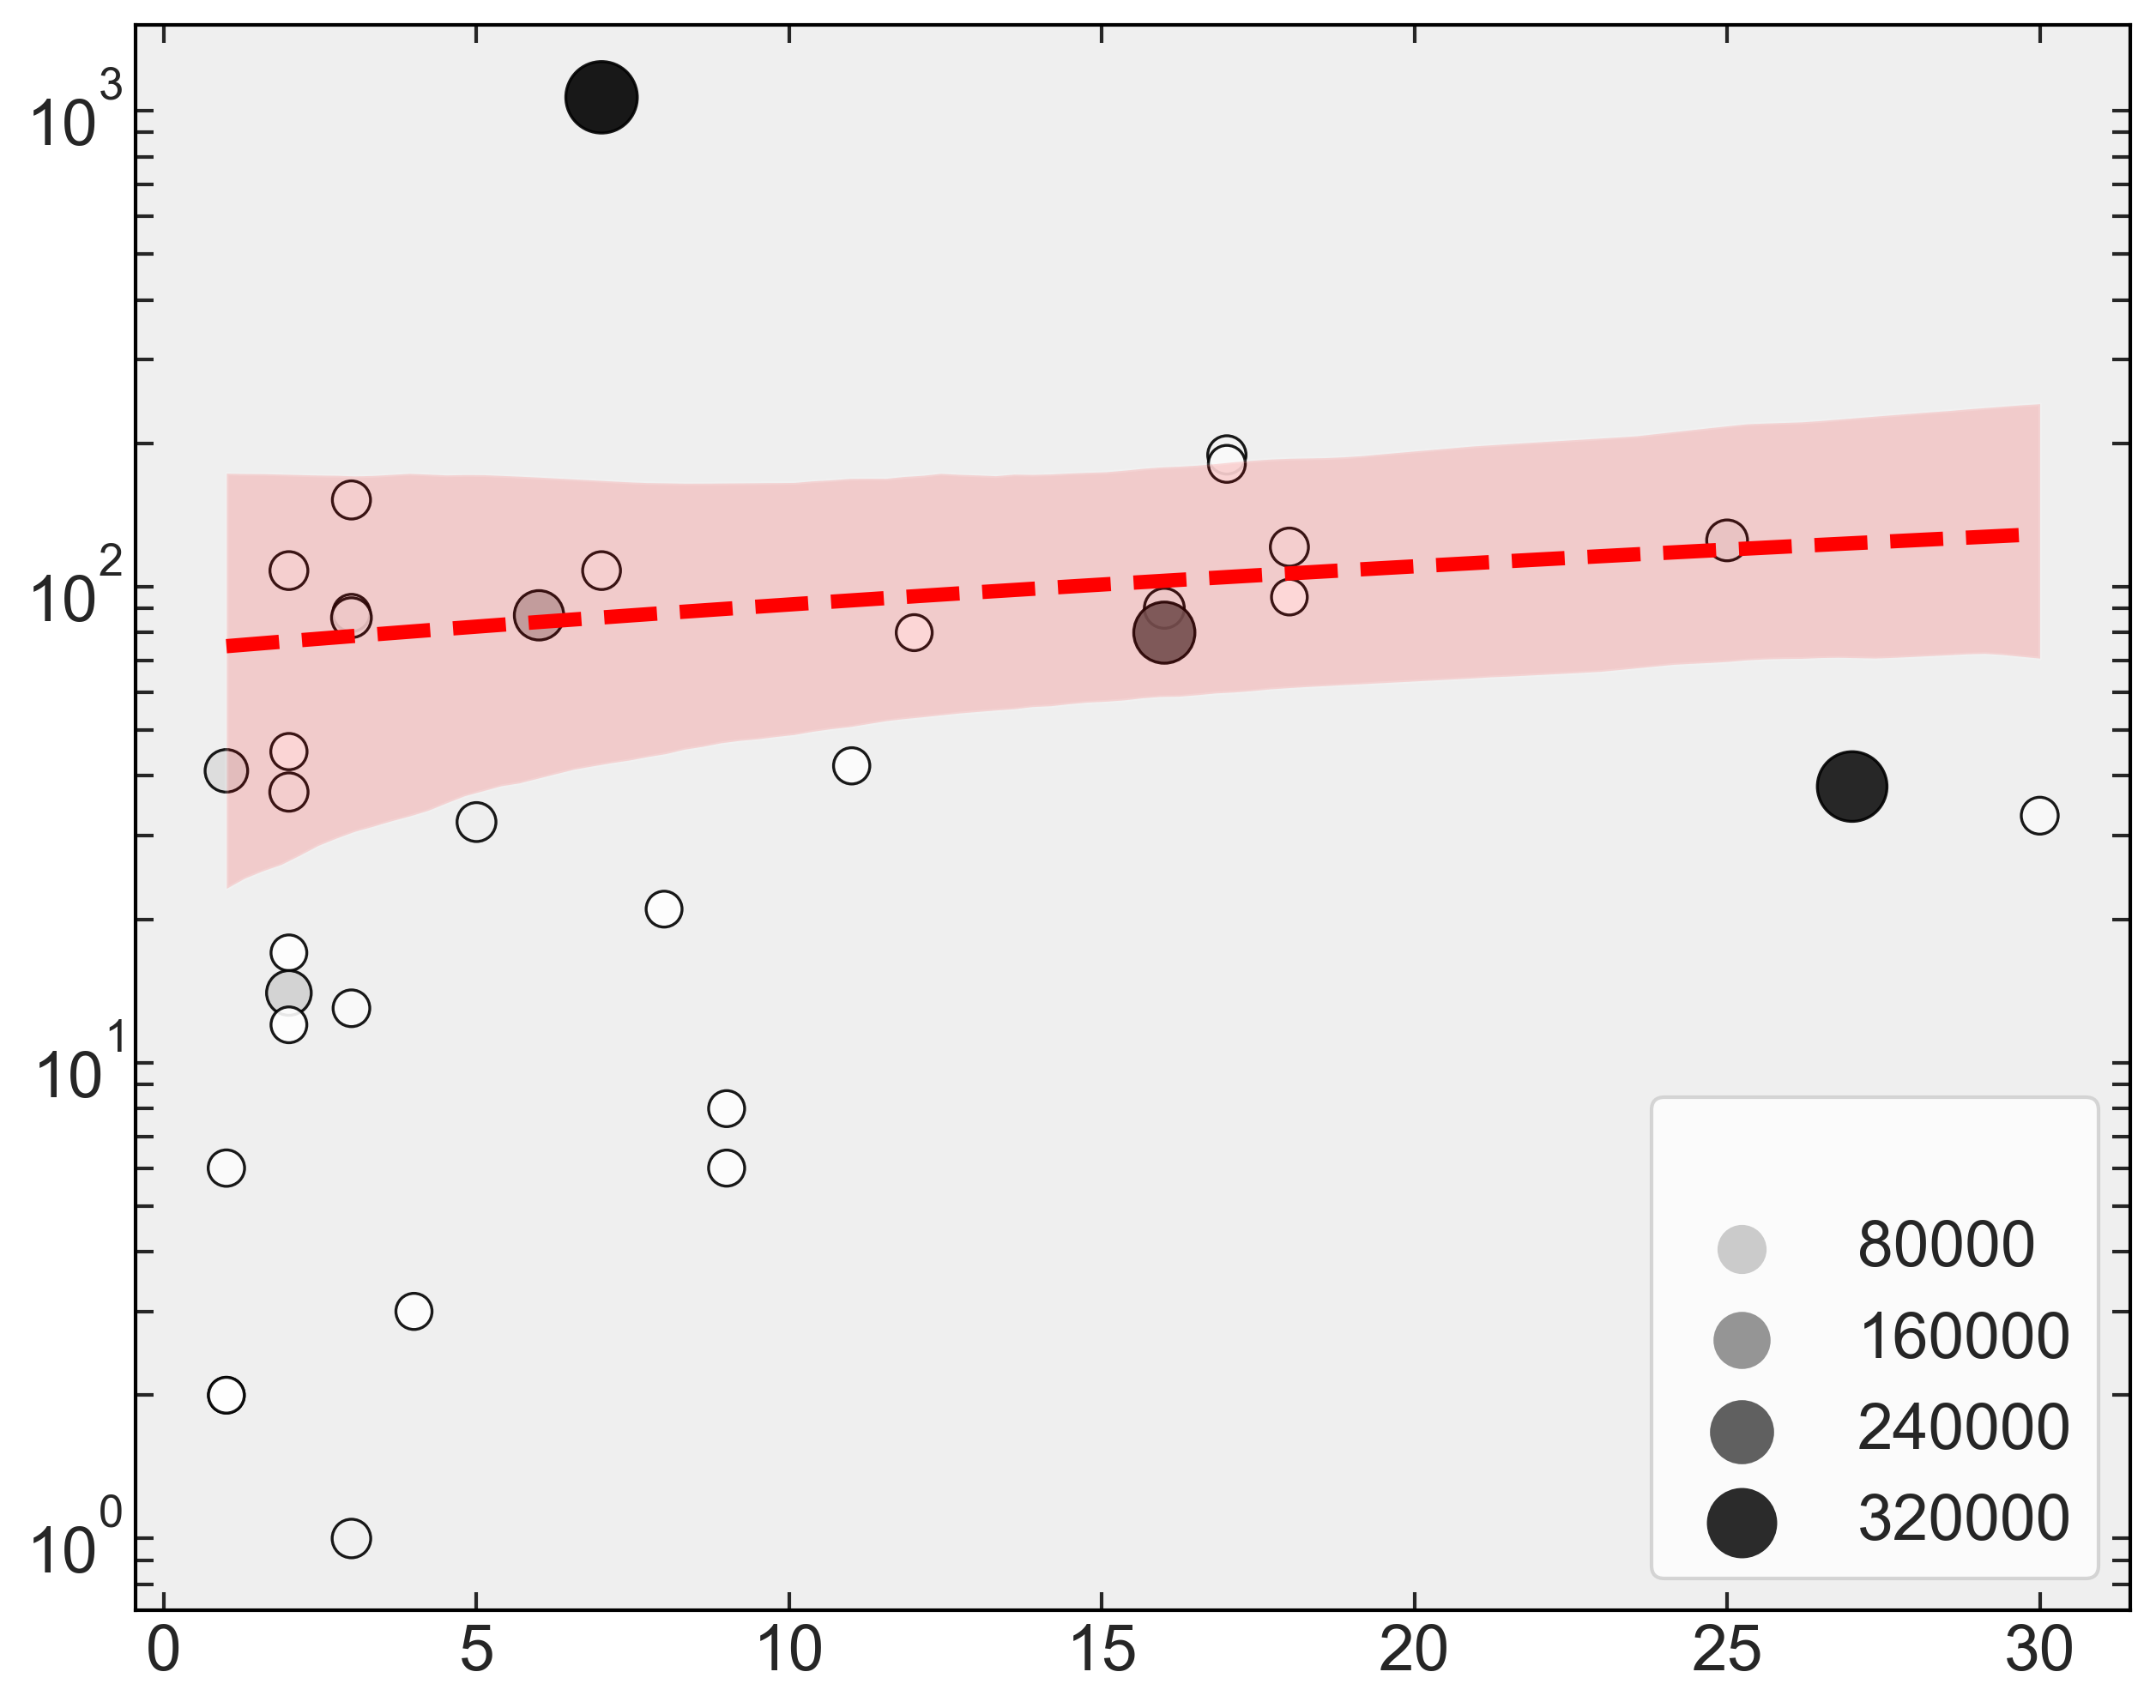

In [213]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def plot_forms_data(save=False):
    """
    Load and plot processed forms data.
    """
    
    # Load data  
    form_count_2022_df = pd.read_excel(Path('../data/processed/202212-govuk-organisations-with-forms-processed.xlsx'))
    form_views_2022_df = pd.read_excel(Path('../data/processed/202211-form-services-pageviews-processed.xlsx'))
    services_2023_df = pd.read_excel(Path('../data/processed/202308-services-list-processed.xlsx'))
    
    # Rename the 'total' column to 'form_count'
    form_count_2022_df = form_count_2022_df.rename(columns={'total': 'form_count'})
    
    # Group by and get the sum of 'form_views'
    form_views_2022_df = form_views_2022_df.groupby(
    'organisation')[['views']].sum().reset_index()
    form_views_2022_df.rename(columns={'views': 'form_views'}, inplace=True)
    
    # Group by 'organisation', count 'service', and find the most common 'topic'
    services_2023_df = services_2023_df.groupby('organisation').agg({
    'service': 'count',
    'topic': lambda x: x.mode().iloc[0] if not x.empty else None
    }).reset_index()
    
    # Rename  columns
    services_2023_df.columns = ['organisation', 'service_count', 'topic']
    
    # Create a new DataFrame with the selected columns
    services_2023_df = services_2023_df[['organisation', 'service_count', 'topic']]
    
    # Merge the two DataFrames on 'organisation'
    merged_df = pd.merge(form_count_2022_df, form_views_2022_df, on='organisation')
    merged_df = pd.merge(merged_df, services_2023_df, on='organisation', how='inner')
    
    # Compute the Pearson correlation coefficient between 'service_count' and 'form_count'
    corr_coefficient, _ = pearsonr(merged_df['service_count'], np.log(merged_df['form_count']))
    
    # Set font to Helvetica
    plt.rcParams['font.family'] = 'Helvetica'
    
    # Create a bubble plot with a regression line
    plt.figure(figsize=(10, 8), dpi=300)
    sns.set_style("whitegrid")  # Remove gridlines
    
    # Plot form_count against services on logarithmic scales, color-coded by 'topic'
    g = sns.scatterplot(
    data=merged_df, 
    x='service_count', 
    y='form_count', 
    size=merged_df['form_views'], 
    sizes=(100, 400), 
    hue=merged_df['form_views'],
    palette='gist_yarg',
    marker='o', 
    alpha=0.9)
    
    # Set y-axis to logarithmic scale
    plt.yscale('log')
    
    # Set the face color
    plt.gca().set_facecolor('#efefef')
    
    # Remove gridlines
    plt.grid(False)
    
    # Add major and minor ticks facing inwards
    plt.tick_params(
    axis='both',
    which='both',
    direction='in',
    top=True,
    right=True,
    bottom=True,
    left=True,
    labelsize=18,
    width=1,
    length=5
    )
    
    # Set border color to black
    g.get_children()[0].set_edgecolor('black')
    
    # Add a legend 
    legend = plt.legend(title=' ', loc='lower right', fontsize=18, title_fontsize=20)
    
    # Set marker scale to 3.5 only for 'topic'
    for handle in legend.legendHandles:
        if str(handle.get_label()) in merged_df.topic.unique():
            handle._sizes = [3.5] if handle.get_label() in merged_df.topic.unique() else [3.5]
    
    # Set the title to include the Pearson correlation coefficient
    # plt.title(f'Pearson $ρ$ = {corr_coefficient:.2f}\n', fontsize=20)
    
    # Add a regression line to the scatterplot
    sns.regplot(data=merged_df, 
            x='service_count', 
            y='form_count', 
            scatter=False, 
            ax=g, 
            color='red', 
            line_kws={"linestyle": "--",
                      "linewidth": 4})
    
    
    # Modify the spines
    g.spines['top'].set_color('black')   
    g.spines['right'].set_color('black')  
    g.spines['left'].set_linewidth(1)
    g.spines['left'].set_color('black')
    g.spines['bottom'].set_linewidth(1)
    g.spines['bottom'].set_color('black')
    g.spines['right'].set_linewidth(1)
    g.spines['top'].set_linewidth(1)
    
    # Set axis labels and font size
    plt.xlabel('', fontsize=18)
    plt.ylabel('', fontsize=18)
    
    # Save figure
    if save == True:
        plt.savefig(Path("../reports/figures/fig2c.png"), dpi=300, bbox_inches='tight')
    else:
        plt.show()

plot_forms_data(save=True)

### Figure 2d

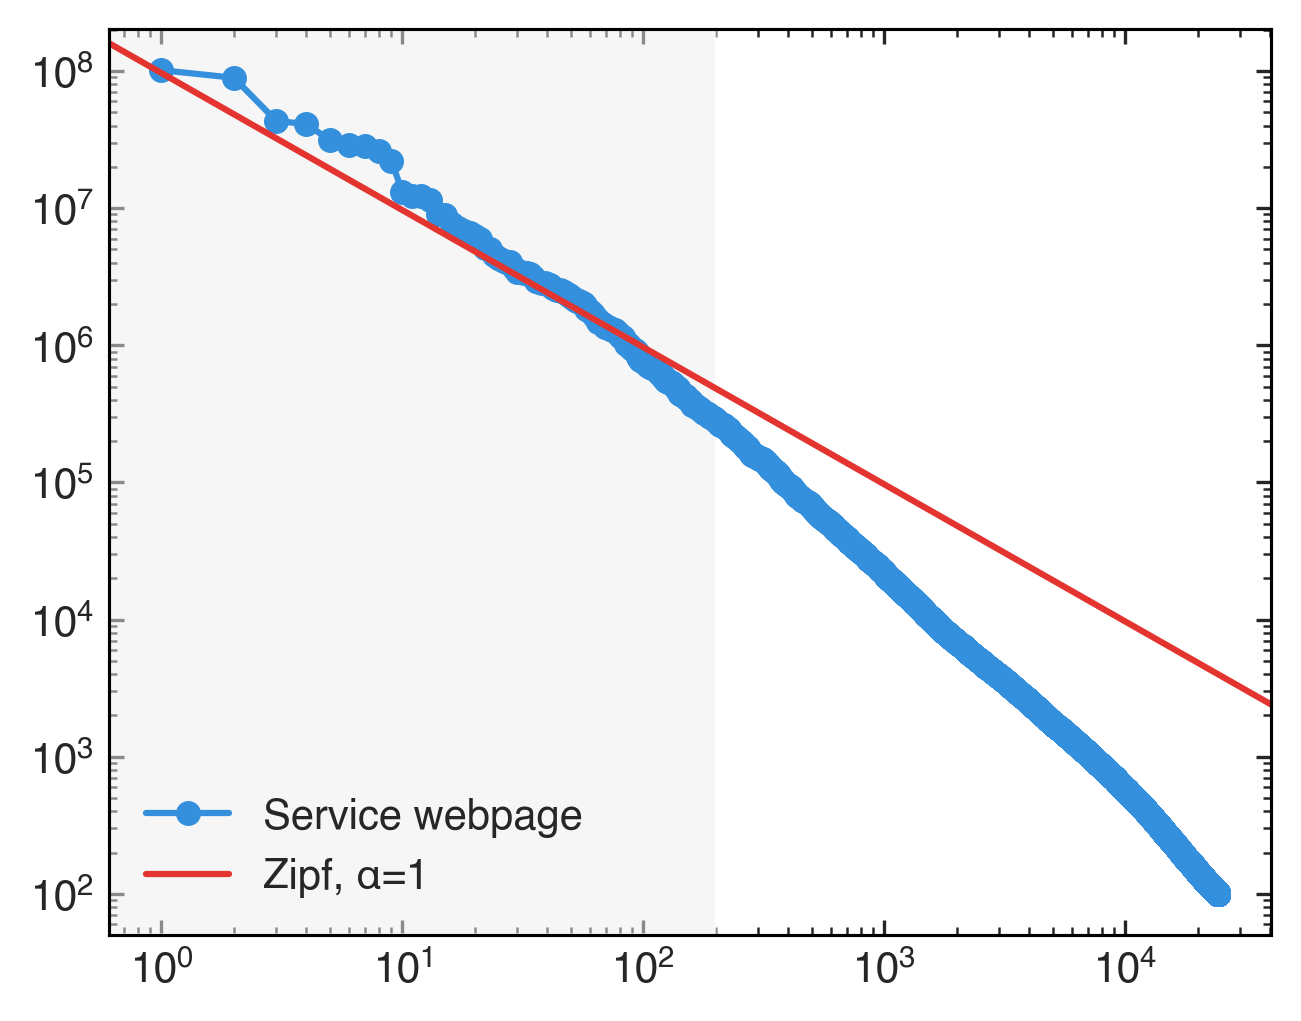

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

def plot_visits_data(save=False):
    """
    Load and plot processed visitor data.
    """

    # Load and preprocess the data
    visits2022_data = pd.read_excel('../data/processed/202110-202209-govuk-unique-visitors-processed.xlsx')
    visits_data = visits2022_data[['Page', 'Unique clicks']].dropna(subset=['Unique clicks'], how='any')
    visits_data.rename(columns={'Unique clicks': 'visits', 'Page': 'page'}, inplace=True)
    visits_data.sort_values('visits', ascending=False, inplace=True)

    n = len(visits_data)
    ranks = range(1, n+1)
    visits_data['rank'] = ranks
    freqs = list(visits_data.visits)

    # Create the figure and axis
    figure = plt.figure(figsize=(5, 4), dpi=300)
    plt.rcParams["font.family"] = "Helvetica"
    ax = plt.subplot()

    line1, = ax.plot(ranks, freqs, linestyle="-", color='#3490dc', fillstyle='full',
                     marker="o", markersize=3, markeredgewidth=3, label='Service webpage')

    line2 = ax.axline((1, 96845562), slope=-1, color='#e3342f', label='Zipf, α=1')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False)

    # Add a legend
    plt.legend(handles=[line1, line2], frameon=False, fancybox=False, loc='lower left',
               facecolor='white', framealpha=1, edgecolor='black', fontsize=10)

    # Highlight an area with axvspan
    plt.axvspan(0, 200, facecolor='#EFEFEF', alpha=0.5)

    # Add major and minor ticks facing inwards
    ax.tick_params(
        axis='both',
        which='both',
        direction='in',
        top=True,
        right=True,
        bottom=True,
        left=True
    )

    # Set the log scale on the y-axis
    plt.yscale("log")
    plt.xscale("log")

    # Modify the spines
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_linewidth(.75)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(.75)
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_linewidth(.75)
    ax.spines['top'].set_linewidth(.75)
    ax.spines['bottom'].set_linewidth(.75)

    # Save figure
    if save == True:
        plt.savefig("../reports/figures/fig2d.png", bbox_inches='tight', dpi=300)
    else:
        plt.show()

# Call the function to plot the data
plot_visits_data(save=True)

/var/folders/5f/f4nt1g8x77ggbhbbvwpth89c0000gr/T/ipykernel_15398/3078432953.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits12_df['visits'] = visits12_df.sum(axis=1, numeric_only=True)
/var/folders/5f/f4nt1g8x77ggbhbbvwpth89c0000gr/T/ipykernel_15398/3078432953.py:62: UserWarning: The handle <matplotlib.lines._AxLine object at 0x7ff571a43dc0> has a label of '_child1' which cannot be automatically added to the legend.
  plt.legend(


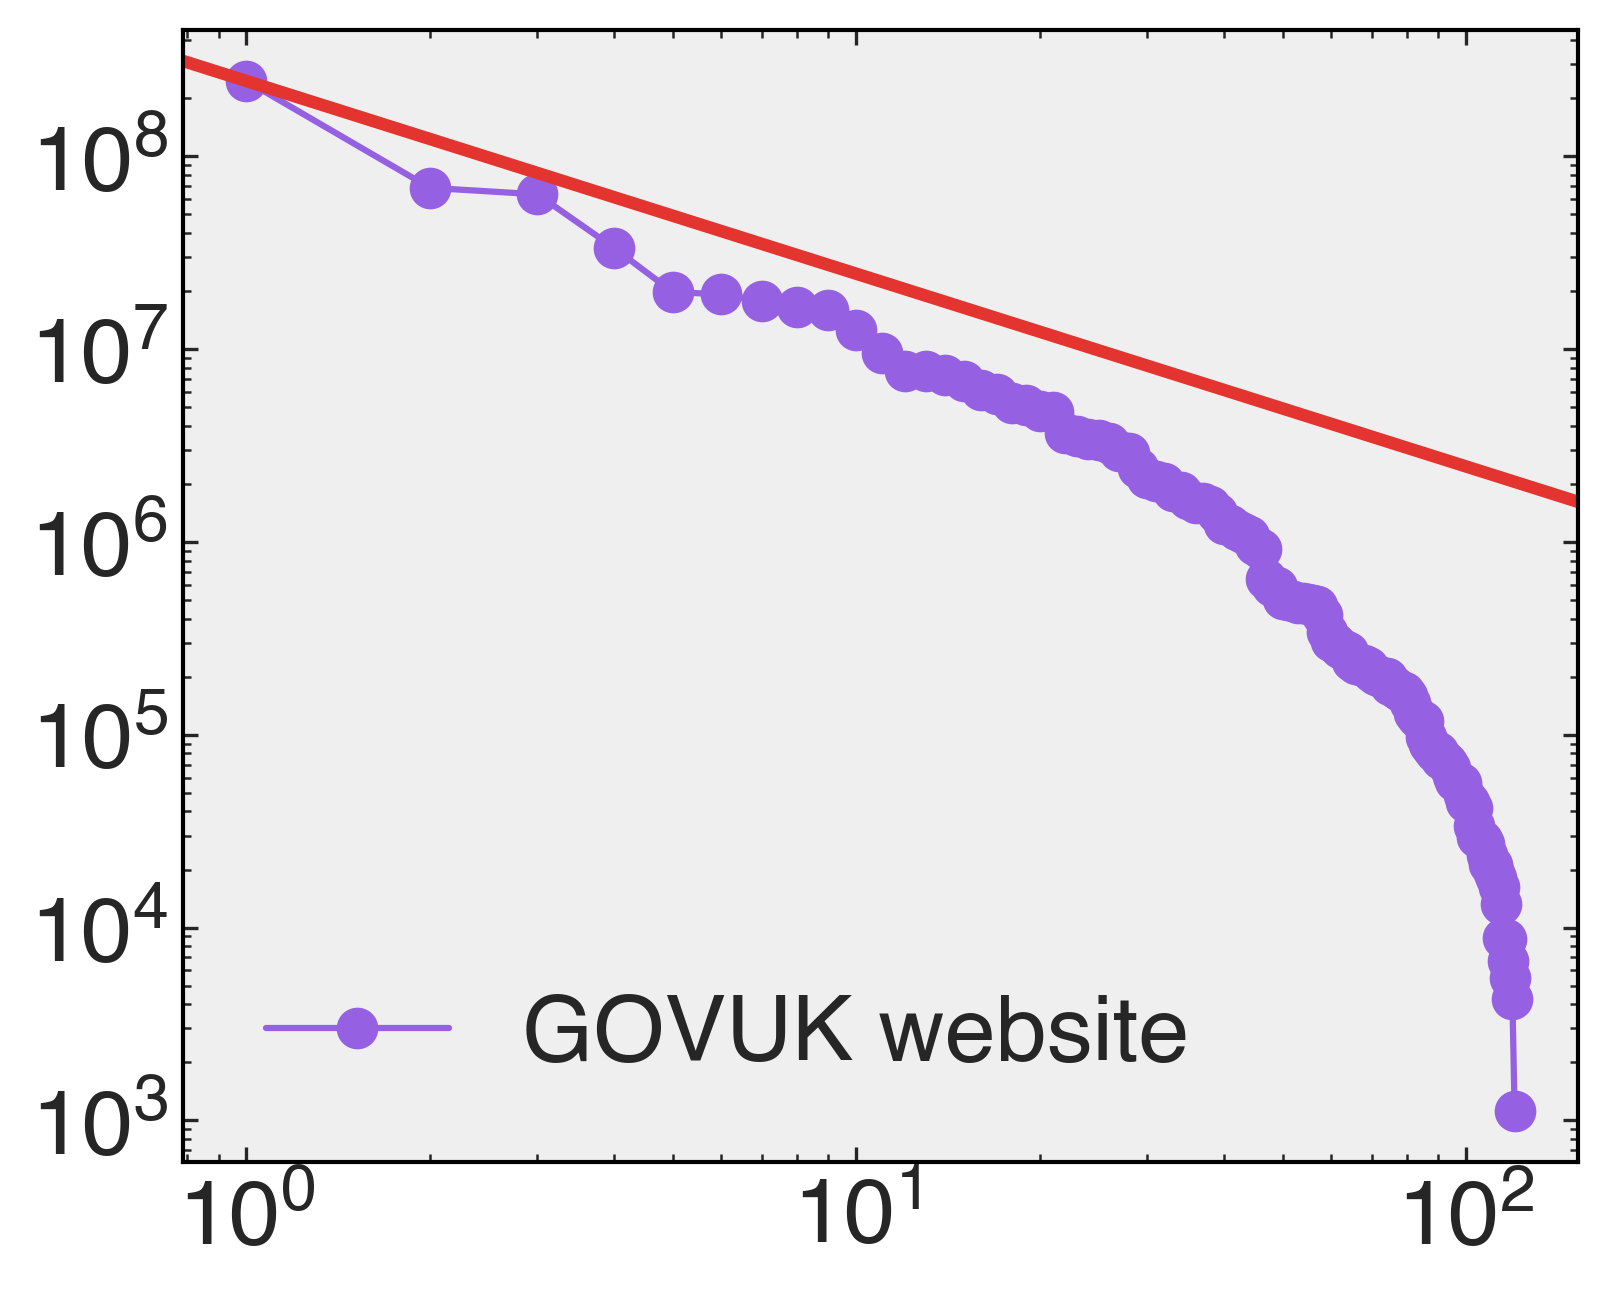

In [130]:
def plot_2012_visits_data(save=False):
    """
    Plot the visits data for GOVUK websites in 2012.

    Parameters:
        save (bool): If True, save the plot as a file. Default is False.

    Returns:
        None
    """
    # Load and preprocess the data
    visits2012_data = pd.read_csv(Path('../data/processed/201104-201203-govuk-unique-visitors-processed.csv'))
    visits2012_data.columns = [i.replace('_', '') for i in visits2012_data.columns]
    visits12_df = visits2012_data.dropna(how='any')
    visits12_df['visits'] = visits12_df.sum(axis=1, numeric_only=True)
    visits12_df = visits12_df.loc[:, ['URL', 'visits']].sort_values('visits', ascending=False)

    # Combine the top two rows
    visits12_df.iloc[0, 1] = visits12_df.iloc[0, 1] + visits12_df.iloc[1, 1]
    visits12_df.drop(3, inplace=True)
    visits12_df = visits12_df.reset_index().drop(columns='index')

    n = len(visits12_df)
    ranks = range(1, n + 1)
    visits12_df['rank'] = ranks
    freqs = list(visits12_df.visits)

    # Create the figure and axis
    figure = plt.figure(figsize=(6,5), dpi=300)
    plt.rcParams["font.family"] = "Helvetica"
    ax = plt.subplot()

    line1, = ax.plot(ranks, freqs, linestyle="-", color='#9561e2', fillstyle='full',
                     marker="o", markersize=5, markeredgewidth=5, label='GOVUK website')
    line2 = ax.axline((1, freqs[0]), slope=-1, color='#e3342f', linewidth=3)

    # Set the face color
    plt.gca().set_facecolor('#efefef')

    ax.set_xlabel('',  fontsize=22)
    ax.set_ylabel('',  fontsize=22)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False)  # Remove gridlines

    # Add major and minor ticks facing inwards
    ax.tick_params(
        axis='both',
        which='both',
        direction='in',
        top=True,
        right=True,
        bottom=True,
        left=True
    )

    # Axis label size
    plt.xticks(fontsize = 22) 
    plt.yticks(fontsize = 22) 

    
    plt.legend(
        handles=[line1, line2], frameon=False, fancybox=False, loc='lower left',
        facecolor='white', framealpha=1, edgecolor='black', fontsize=22,
    )

    # Modify the spines
    ax.spines['top'].set_color('black')  # Remove top spine
    ax.spines['right'].set_color('black')  # Remove right spine
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)

    # Save figure
    if save == True:
        plt.savefig("../reports/figures/fig2d-inset.png", dpi=300)
    else:
        plt.show()

# Usage
plot_2012_visits_data(save=True)

### Figure 2ef

In [7]:
import os 
os.getcwd()

'/Users/vstraub/Documents/github-repos/decision-services-index/notebooks'

[nltk_data] Downloading package wordnet to /Users/vstraub/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/vstraub/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/var/folders/5f/f4nt1g8x77ggbhbbvwpth89c0000gr/T/ipykernel_87512/1071218430.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verbs_2012_df['verb'] = verbs_2012_df['Service'].apply(extract_first_verb)
/var/folders/5f/f4nt1g8x77ggbhbbvwpth89c0000gr/T/ipykernel_87512/1071218430.py:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(top_10_verbs['verb'], fontsize=20)
/var/folders/5f/f4nt1g8x77ggbhbbvwpth89c0000gr/T/ipykernel_87512/1071218430.py:111: UserW

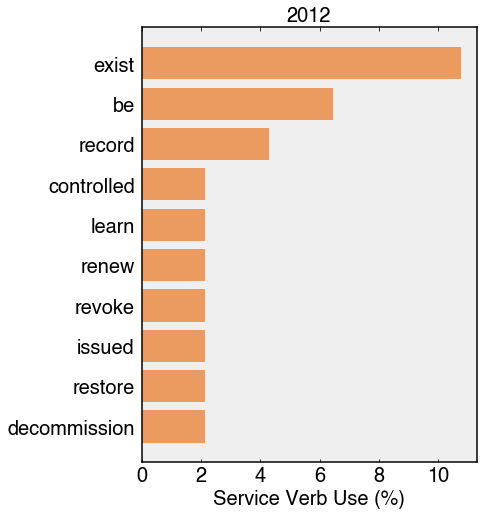

In [11]:
# Define function to extract the first verb from a text
def extract_first_verb(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    
    for word, pos in pos_tags:
        if pos.startswith('V'):
            return word
    
    return None
    
# Load data
transactions_data = pd.read_csv(
    '../data/processed/201204-201703-service-transactions-processed.csv'
)

# Function to lemmatize a verb
def lemmatize_verb(verb):
    # Define the part of speech (POS) for WordNet lemmatizer
    pos = wordnet.VERB if verb.endswith('e') else wordnet.VERB if 'ing' in verb else wordnet.NOUN
    
    # Lemmatize the verb
    return lemmatizer.lemmatize(verb, pos)

# Extract the first word from each string
verbs_2012_df = transactions_data.loc[(transactions_data['201212'] > 0)]
first_words = verbs_2012_df['Service'].str.split().str[0]

# Convert the result to a list
first_words_list = first_words.tolist()

# Check if 'punkt' and 'averaged_perceptron_tagger' are downloaded; if not, download them
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('taggers/averaged_perceptron_tagger')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
except LookupError:
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

# Apply the exatract_first_verb function to create the 'verb' column
verbs_2012_df['verb'] = verbs_2012_df['Service'].apply(extract_first_verb)

# Format DataFrame
verbs_2012_df = pd.DataFrame.from_dict(verbs_2012_df.verb.value_counts()).reset_index()
verbs_2012_df.rename(columns={'index': 'verb', 'verb': 'freq'}, inplace=True)
verbs_2012_df['verb'] = verbs_2012_df['verb'].str.lower()

# Add percentage for each verb
verbs_2012_df['perc'] = (verbs_2012_df['freq'] / verbs_2012_df['freq'].sum()) * 100

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to the 'verb' column to get root form of verbs
verbs_2012_df['verb'] = verbs_2012_df['verb'].apply(lemmatize_verb)

# Set the font to Helvetica
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

# Create a new figure with a white background
fig, ax = plt.subplots(figsize=(6, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('#efefef')

# Plot the chart for the top 10 verbs
top_10_verbs = verbs_2012_df.head(10)
plt.barh(top_10_verbs['verb'], top_10_verbs['perc'], color='#eb9a60')

# Add title and labels
plt.xlabel('Service Verb Use (%)', fontsize=20)
plt.title('2012', fontsize=20)
plt.ylabel('')

# Format the plot
plt.gca().invert_yaxis()
ax.grid(False)  # Remove gridlines

# Set tick labels
ax.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,
    labelright=False
)

ax.tick_params(
    axis='x',
    which='minor',
    top=False,
    bottom=False,
    labelright=False
)

ax.tick_params(
    direction='in',
    axis='x',
    which='major',
    top=True,
    bottom=True,
    labelright=False
)

# Set axes labels and font size
ax.set_yticklabels(top_10_verbs['verb'], fontsize=20)
ax.set_xticklabels([0, 2, 4, 6, 8, 10], fontsize=20)


# Modify the spines
ax.spines['top'].set_color('black')  # Remove top spine
ax.spines['right'].set_color('black')  # Remove right spine
ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)

# Save figure
plt.savefig("../reports/figures/fig2e1.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Figure 2f2

/var/folders/5f/f4nt1g8x77ggbhbbvwpth89c0000gr/T/ipykernel_87512/3209334897.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(verbs_2022_df.verb, fontsize=20)


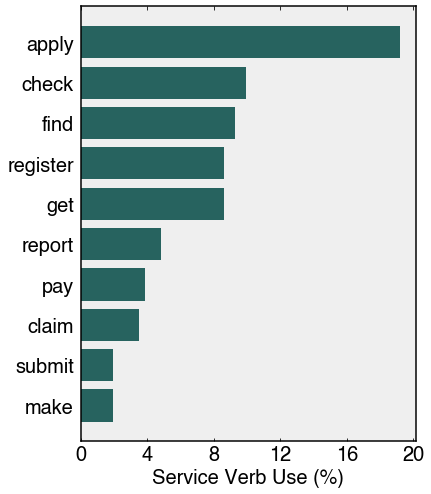

In [15]:
def load_and_process_data(file_path):
    """
    Load and process service verb data from an Excel file.

    Args:
        file_path (str): Path to the Excel file containing service verb data.

    Returns:
        pd.DataFrame: Processed DataFrame with verb frequencies and percentages.
    """
    # Load data from the Excel file
    services_data = pd.read_excel(file_path)

    # Get verb frequencies
    verbs = services_data['verb'].value_counts()

    # Create a DataFrame to store verb frequencies
    verbs_df = pd.DataFrame({'verb': verbs.index, 'freq': verbs.values})

    # List of verbs to exclude
    excluded_verbs = [
        'Apply', 'Check', 'Get', 'Register', 'Find', 'Report', 'Claim',
        'View', 'Pay', 'Submit', 'Manage', 'Book', 'Make', 'Create',
        'Appeal', 'Search', 'File', 'Use', 'Send', 'Sign', 'Ask', 'Explore',
        'Publish', 'Change', 'Prove', 'Plan', 'Look', 'Order', 'Tell', 'Help',
        'Fill', 'Support', 'Refer', 'Declare', 'Request', 'Complain', 'Accept',
        'Verify', 'Update', 'Cancel', 'Remove', 'Recruit', 'Calculate', 'Track',
        'Renew', 'Give', 'Record', 'Respond', 'Comply', 'Complete', 'Analyse',
        'Replace', 'Download', 'Repay', 'Add', 'Visit', 'Reply', 'Evict', 'Offer'
    ]

    # Filter out non-verbs
    verbs_df = verbs_df[~verbs_df["verb"].isin(excluded_verbs) == False]

    # Convert verbs to lowercase
    verbs_df['verb'] = verbs_df['verb'].str.lower()

    # Calculate verb frequencies as percentages
    verbs_df['perc'] = (verbs_df['freq'] / verbs_df['freq'].sum()) * 100

    return verbs_df

# Specify the file path for the Excel data
file_path = '../data/processed/202308-services-list-processed.xlsx'

# Load and process the data
verbs_2022_df = load_and_process_data(file_path)

# Set the font to Helvetica
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

# Create a new figure with a white background
fig, ax = plt.subplots(figsize=(6, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('#efefef')

# Plot the chart
plt.barh(verbs_2022_df.iloc[:10, :].verb, verbs_2022_df.iloc[:10, :].perc, color='#27635f')

# Add title and labels
plt.title('', fontsize=18)
plt.xlabel('Service Verb Use (%)', fontsize=20)
plt.ylabel('')

# Format the plot
plt.gca().invert_yaxis()
ax.grid(False)  # Remove gridlines

# Set tick labels
ax.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,
    labelright=False
)

ax.tick_params(
    axis='x',
    which='minor',
    top=False,
    bottom=False,
    labelright=False
)

ax.tick_params(
    direction='in',
    axis='x',
    which='major',
    top=True,
    bottom=True,
    labelright=False
)


# Set axes labels and font size
plt.xticks(range(0, 21, 4), fontsize=20)
ax.set_yticklabels(verbs_2022_df.verb, fontsize=20)

# Modify the spines
ax.spines['top'].set_color('black')  # Remove top spine
ax.spines['right'].set_color('black')  # Remove right spine
ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)

plt.savefig("../reports/figures/fig2e2.png", dpi=300, bbox_inches='tight');